In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot  as plt
from matplotlib.pyplot import imshow,imread
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array
import tensorflow as tf
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

,ID,Male,Boneage,Zscore
0,1377.png,0,180,1.279181
1,1378.png,0,12,-2.800269
2,1379.png,0,94,-0.809109
3,1380.png,1,120,-0.177766
4,1381.png,0,82,-1.100498
...,...,...,...,...
12606,15605.png,0,50,-1.877537
12607,15606.png,0,113,-0.347743
12608,15608.png,0,55,-1.756124
12609,15609.png,1,150,0.550708


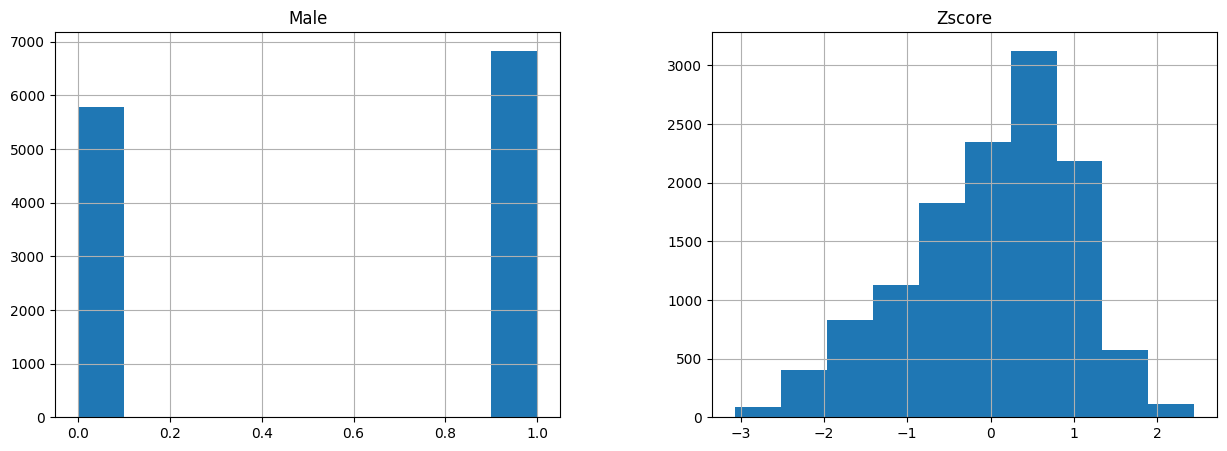

In [2]:
data_df = pd.read_csv('dataset/RSNA_Annotations/RSNA_Annotations/BONEAGE/boneage_train.csv')
data_df ['ID'] = data_df['ID'].map(lambda x: f'{x}.png')
data_df['Male']= data_df['Male'].map(lambda x: 1 if (x == True) else 0)
mean = data_df['Boneage'].mean()
stdd = data_df['Boneage'].std()
data_df['Zscore']= data_df['Boneage'].map(lambda x:(x-mean)/stdd)
data_df[['Male','Zscore']].hist(figsize=(15,5))
data_df

In [3]:
test_df = pd.read_csv('dataset/RSNA_Annotations/RSNA_Annotations/BONEAGE/gender_test.csv')
test_df['ID'] = test_df['ID'].map(lambda x: f'{x}.png')

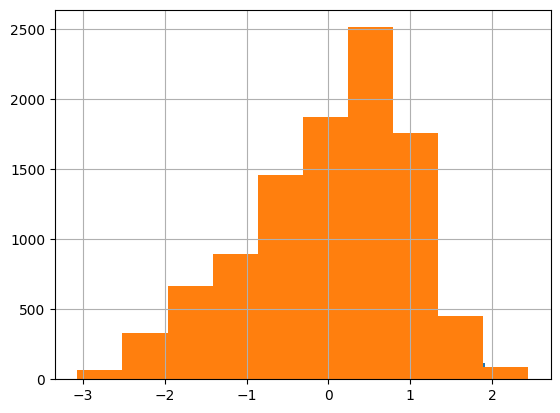

In [4]:
train_df = data_df.sample(frac=0.2)
valid_df = data_df.drop(train_df.index)


ax = [train_df['Zscore'].hist() ,valid_df['Zscore'].hist()]

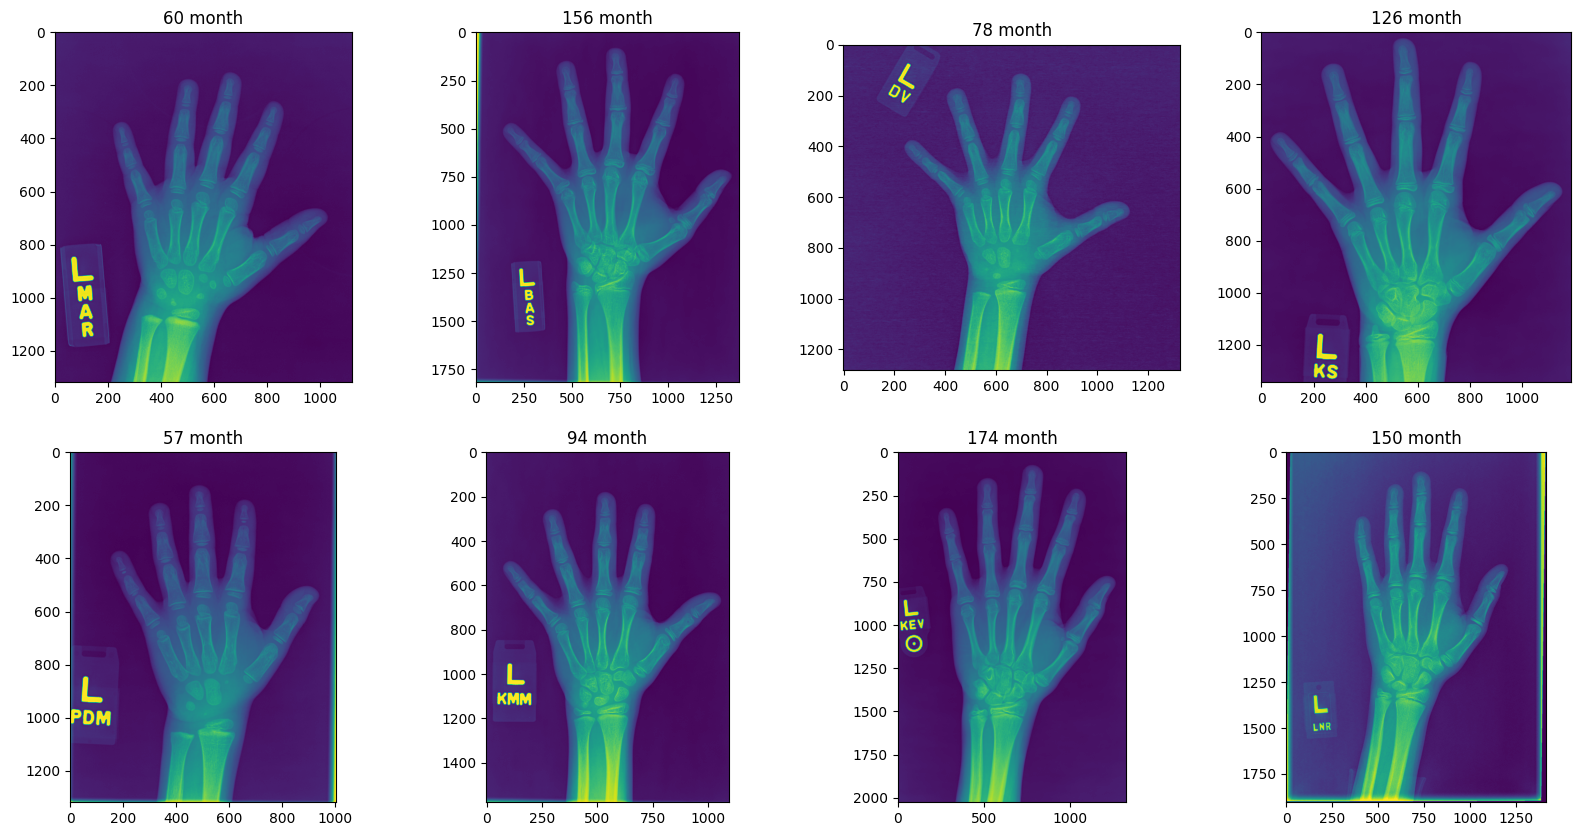

In [5]:
train_dir='dataset/RSNA_train/images'
test_dir= 'dataset/RSNA_test/images'
sample = data_df.sample(n=8)
fig,axx = plt.subplots(2,4, figsize=(20,10))
for idd,boneage,place in zip(sample['ID'],sample['Boneage'],axx.flatten()):
    place.imshow(imread(f"{train_dir}/{idd}"))
    place.set_title(str(boneage)+' month')

In [29]:
core_dg = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.1,
    fill_mode="nearest",
    cval=0.0,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2,
    dtype=None,
    preprocessing_function = tf.keras.applications.xception.preprocess_input
)

In [74]:
train_dg = core_dg.flow_from_dataframe(
    train_df,
    directory=train_dir,
    x_col="ID",
    y_col="Boneage",
    weight_col=None,
    target_size=(256, 256),
    color_mode="grayscale",
    classes=None,
    class_mode="raw",
    batch_size=32,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    subset=None,
    interpolation="nearest",
    validate_filenames=True,
)

Found 2522 validated image filenames.


In [75]:
valid_dg = core_dg.flow_from_dataframe(
    valid_df,
    directory=train_dir,
    x_col="ID",
    y_col="Boneage",
    weight_col=None,
    target_size=(256, 256),
    color_mode="grayscale",
    classes=None,
    class_mode="raw",
    batch_size=32,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    subset=None,
    interpolation="nearest",
    validate_filenames=True,
)

Found 10089 validated image filenames.


In [76]:
test_dg_core = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = tf.keras.applications.xception.preprocess_input)
test_dg = test_dg_core.flow_from_dataframe(test_df,
                                          x_col='ID',
                                          directory = test_dir,
                                          class_mode = None)

Found 200 validated image filenames.


In [77]:
from keras import Sequential
from keras.layers import Dense,MaxPooling2D,Input,Conv2D,Dropout,BatchNormalization,GlobalMaxPooling2D,Flatten
from keras.applications.xception import Xception
from keras.metrics import MeanAbsoluteError
from keras.models import Model

In [96]:
input_shape=(256,256,1)
dropout_rate = 0.35

model_input= Input(shape=input_shape)

x = Conv2D(32,(3,3),activation='relu',padding='same')(model_input)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Conv2D(64,(3,3),activation='relu',padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(dropout_rate)(x)

x = Conv2D(128,(3,3),activation='relu',padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(dropout_rate)(x)

x = Conv2D(256,(3,3),activation='relu',padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(dropout_rate)(x)

x = Flatten()(x)
x = Dense(50,activation='relu')(x)
x = Dense(10,activation='relu')(x)
model_output = Dense(1,activation='linear')(x)


In [97]:
model = Model(model_input,model_output)

model.compile(loss='mse',optimizer='adam',metrics=[MeanAbsoluteError()])
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_46 (Conv2D)          (None, 256, 256, 32)      320       
                                                                 
 batch_normalization_45 (Bat  (None, 256, 256, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 batch_normalization_46 (Bat  (None, 128, 128, 64)     256

 g2D)                                                            
                                                                 
 dropout_31 (Dropout)        (None, 64, 64, 64)        0         
                                                                 
 conv2d_48 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 batch_normalization_47 (Bat  (None, 64, 64, 128)      512       
 chNormalization)                                                
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 32, 32, 128)      0         
 g2D)                                                            
                                                                 
 dropout_32 (Dropout)        (None, 32, 32, 128)       0         
                                                                 
 conv2d_49 (Conv2D)          (None, 32, 32, 256)       295168    
          

In [114]:
model.fit_generator(train_dg, epochs = 2)

C:\Users\prkna\AppData\Local\Temp\ipykernel_13892\1359375472.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_dg, epochs = 10)


Epoch 1/10
79/79 [==============================] - 59s 741ms/step - loss: 1674.7834 - mean_absolute_error: 32.8377
Epoch 2/10
79/79 [==============================] - 56s 711ms/step - loss: 1654.8818 - mean_absolute_error: 32.6033
Epoch 3/10
79/79 [==============================] - 56s 712ms/step - loss: 1563.5898 - mean_absolute_error: 31.8519
Epoch 4/10
79/79 [==============================] - 56s 704ms/step - loss: 1514.9559 - mean_absolute_error: 31.3354
Epoch 5/10
79/79 [==============================] - 56s 703ms/step - loss: 1440.7676 - mean_absolute_error: 30.3637
Epoch 6/10
79/79 [==============================] - 55s 698ms/step - loss: 1414.9154 - mean_absolute_error: 30.3872
Epoch 7/10
33/79 [===========>..................] - ETA: 31s - loss: 1389.6835 - mean_absolute_error: 29.9471

KeyboardInterrupt: 

In [ ]:
model.save(filepath='checkpoint.h5')

In [ ]:
import cv2

img = cv2.imread('dataset/RSNA_train/images/1377.png')  
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
img = cv2.resize(img, (256, 256))
img = img.reshape((1, 256, 256, 1))  
print(img.shape)  

(1, 256, 256, 1)


In [ ]:

res = model.predict(img)

print(res)

1/1 [==============================] - 0s 38ms/step
[[4320.273]]
